In [1]:
# Autoimport on changes
%load_ext autoreload
%autoreload 2

# Import commonly used libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# graphics
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# type annotation
import jaxtyping
from jaxtyping import Float32, Int64, jaxtyped
from typeguard import typechecked as typechecker

# more itertools
import more_itertools as mi

# itertools
import itertools
import collections

# tensor manipulation
from einops import rearrange, reduce, repeat

# automatically apply jaxtyping
# %load_ext jaxtyping
# %jaxtyping.typechecker typeguard.typechecked

In [2]:
def get_best_available_device() -> torch.device:
    """
    Determine and return the best available PyTorch device.

    This function checks for CUDA and MPS availability, returning the appropriate device
    in the following order of preference: CUDA (GPU) > MPS (Apple Silicon) > CPU.

    Returns:
        torch.device: The best available PyTorch device (CUDA > MPS > CPU).
    """
    if torch.cuda.is_available():
        return torch.device("cuda")  # Use CUDA GPU if available
    elif torch.backends.mps.is_available():
        return torch.device("mps")  # Use Apple Silicon GPU if available
    else:
        return torch.device("cpu")  # Fallback to CPU if no GPU is available


# Get the best available device
device = get_best_available_device()
print(f"Using device: {device}")

Using device: mps


In [3]:
import torch
from torch.utils.data import Dataset
import numpy as np
from sklearn.datasets import make_moons, make_circles, make_blobs
from typing import Literal, Tuple
from jaxtyping import Float, Int64

import pprint


class GeometricDataset(Dataset):
    def __init__(self, num_samples: int = 1000, noise: float = 0.01):
        """
        Initialize the GeometricDataset with multiple 2D patterns combined into a higher-dimensional space.

        :param num_samples: Total number of samples to generate
        :param noise: Noise level for the patterns
        """
        self.num_samples = num_samples
        self.noise = noise

        # Generate data for each pattern
        X_moons, y_moons = make_moons(
            n_samples=num_samples,
            noise=noise,
            random_state=42,
        )
        X_circles, y_circles = make_circles(
            n_samples=num_samples,
            noise=noise,
            factor=0.5,
            random_state=42,
        )
        X_spirals, y_spirals = self._make_spirals(
            n_samples=num_samples,
            noise=noise,
        )
        X_blobs, y_blobs = make_blobs(
            n_samples=num_samples,
            centers=[[0, 0], [1, 1], [-1, 1], [1, -1]],
            cluster_std=0.3,
            random_state=42,
        )

        # Combine all data into a single 8-dimensional dataset
        self.X = np.hstack((X_moons, X_circles, X_spirals, X_blobs))

        # Store original labels
        self.y_original = np.stack([y_moons, y_circles, y_spirals, y_blobs], axis=1)

        # Create a mapping for unique combinations
        self.label_mapping = self._create_label_mapping(self.y_original)

        # Combine labels using the mapping
        self.y = self._encode_labels(self.y_original)

        # Convert to PyTorch tensors
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.long)
        self.y_original = torch.tensor(self.y_original, dtype=torch.long)

        # Store the number of classes
        self.num_classes = len(self.label_mapping)

    def _make_spirals(
        self,
        n_samples: int,
        noise: float,
    ) -> tuple[np.ndarray, np.ndarray]:
        """Generate two intertwining spirals."""
        n = np.sqrt(np.random.rand(n_samples // 2, 1)) * 780 * (2 * np.pi) / 360
        d1x = -np.cos(n) * n + np.random.randn(n_samples // 2, 1) * noise
        d1y = np.sin(n) * n + np.random.randn(n_samples // 2, 1) * noise
        d2x = np.cos(n) * n + np.random.randn(n_samples // 2, 1) * noise
        d2y = -np.sin(n) * n + np.random.randn(n_samples // 2, 1) * noise

        X = np.vstack((np.hstack((d1x, d1y)), np.hstack((d2x, d2y))))
        y = np.hstack((np.zeros(n_samples // 2), np.ones(n_samples // 2)))

        # Shuffle the points
        idx = np.random.permutation(n_samples)
        return X[idx], y[idx]

    def _create_label_mapping(self, labels: np.ndarray) -> dict:
        """
        Create a mapping from unique label combinations to integers.
        """
        unique_combinations = np.unique(labels, axis=0)
        return {tuple(comb): i for i, comb in enumerate(unique_combinations)}

    def _encode_labels(self, labels: np.ndarray) -> np.ndarray:
        """
        Encode the original labels into a single integer value using the mapping.
        """
        return np.array([self.label_mapping[tuple(label)] for label in labels])

    def decode_labels(self, encoded_labels: torch.Tensor) -> torch.Tensor:
        """
        Decode the encoded labels back to the original binary labels.
        """
        inverse_mapping = {v: k for k, v in self.label_mapping.items()}
        return torch.tensor([inverse_mapping[label.item()] for label in encoded_labels])

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(
        self,
        idx: int,
    ) -> tuple[Float[torch.Tensor, "8"], Int64[torch.Tensor, ""]]:
        return self.X[idx], self.y[idx]

    def visualize(
        self,
        sample_size: int = 1000,
        model: torch.nn.Module | None = None,
    ) -> None:
        """
        Visualize each 2D pattern in the dataset, coloring by the original labels and model predictions if provided.

        :param sample_size: Number of points to plot (to avoid overcrowding)
        :param model: Optional PyTorch model to use for predictions
        """
        import matplotlib.pyplot as plt
        import torch

        device = get_best_available_device()

        # Sample a subset of points if necessary
        if sample_size < len(self.X):
            indices = np.random.choice(len(self.X), sample_size, replace=False)
            X_sample = self.X[indices]
            y_original_sample = self.y_original[indices]
        else:
            X_sample = self.X
            y_original_sample = self.y_original

        # Make predictions if model is provided
        if model is not None:
            with torch.no_grad():
                # Move X_sample to the same device as the model
                X_sample_device = X_sample.to(device)
                # Make predictions using the model
                y_pred = model(X_sample_device).argmax(dim=1)
                # Move predictions back to CPU for further processing
                y_pred_cpu = y_pred.cpu()
                y_pred_original = self.decode_labels(y_pred_cpu)

        fig, axs = plt.subplots(4, 2, figsize=(20, 30))
        patterns = ["Moons", "Circles", "Spirals", "Blobs"]

        for i, pattern in enumerate(patterns):
            ax_truth = axs[i, 0]
            ax_pred = axs[i, 1]

            # Plot ground truth
            scatter_truth = ax_truth.scatter(
                X_sample[:, 2 * i],
                X_sample[:, 2 * i + 1],
                c=y_original_sample[:, i],
                cmap="viridis",
                alpha=0.6,
                s=10,
            )
            ax_truth.set_title(f"{pattern} Pattern - Ground Truth")
            ax_truth.set_xlabel(f"Feature {2*i}")
            ax_truth.set_ylabel(f"Feature {2*i+1}")
            fig.colorbar(scatter_truth, ax=ax_truth, label=f"{pattern} Class")

            # Plot model predictions if available
            if model is not None:
                scatter_pred = ax_pred.scatter(
                    X_sample[:, 2 * i],
                    X_sample[:, 2 * i + 1],
                    c=y_pred_original[:, i],
                    cmap="viridis",
                    alpha=0.6,
                    s=10,
                )
                ax_pred.set_title(f"{pattern} Pattern - Model Predictions")
                ax_pred.set_xlabel(f"Feature {2*i}")
                ax_pred.set_ylabel(f"Feature {2*i+1}")
                fig.colorbar(scatter_pred, ax=ax_pred, label=f"{pattern} Class")
            else:
                ax_pred.axis("off")  # Hide the axis if no model predictions

        plt.tight_layout()
        plt.show()

    def get_class_distribution(self) -> dict[int, int]:
        """
        Get the distribution of encoded classes in the dataset.

        :return: A dictionary with encoded class labels as keys and their counts as values
        """
        return {i: (self.y == i).sum().item() for i in range(self.num_classes)}

    def get_original_class_distributions(self) -> list[dict[int, int]]:
        """
        Get the distribution of original classes for each pattern.

        :return: A list of dictionaries, each with class labels as keys and their counts as values
        """
        return [
            {i: (self.y_original[:, j] == i).sum().item() for i in range(2)}
            for j in range(4)
        ]

    def get_label_mapping(self) -> dict:
        """
        Get the mapping from original label combinations to encoded labels.

        :return: A dictionary with original label combinations as keys and encoded labels as values
        """
        return {str(k): v for k, v in self.label_mapping.items()}

In [4]:
# Create the dataset
dataset = GeometricDataset(num_samples=100, noise=0.01)

# Print class distribution
print("Class distribution:")
pprint.pprint(dataset.get_class_distribution())


print("Label mapping:")
pprint.pprint(dataset.get_label_mapping())

print("Sample Y")
print(dataset.y[:5])

Class distribution:
{0: 10,
 1: 3,
 2: 7,
 3: 5,
 4: 5,
 5: 6,
 6: 5,
 7: 9,
 8: 3,
 9: 7,
 10: 8,
 11: 7,
 12: 7,
 13: 9,
 14: 5,
 15: 4}
Label mapping:
{'(0.0, 0.0, 0.0, 0.0)': 0,
 '(0.0, 0.0, 0.0, 1.0)': 1,
 '(0.0, 0.0, 0.0, 2.0)': 2,
 '(0.0, 0.0, 0.0, 3.0)': 3,
 '(0.0, 0.0, 1.0, 0.0)': 4,
 '(0.0, 0.0, 1.0, 1.0)': 5,
 '(0.0, 0.0, 1.0, 2.0)': 6,
 '(0.0, 0.0, 1.0, 3.0)': 7,
 '(1.0, 1.0, 0.0, 0.0)': 8,
 '(1.0, 1.0, 0.0, 1.0)': 9,
 '(1.0, 1.0, 0.0, 2.0)': 10,
 '(1.0, 1.0, 0.0, 3.0)': 11,
 '(1.0, 1.0, 1.0, 0.0)': 12,
 '(1.0, 1.0, 1.0, 1.0)': 13,
 '(1.0, 1.0, 1.0, 2.0)': 14,
 '(1.0, 1.0, 1.0, 3.0)': 15}
Sample Y
tensor([11,  9, 14,  5,  7])


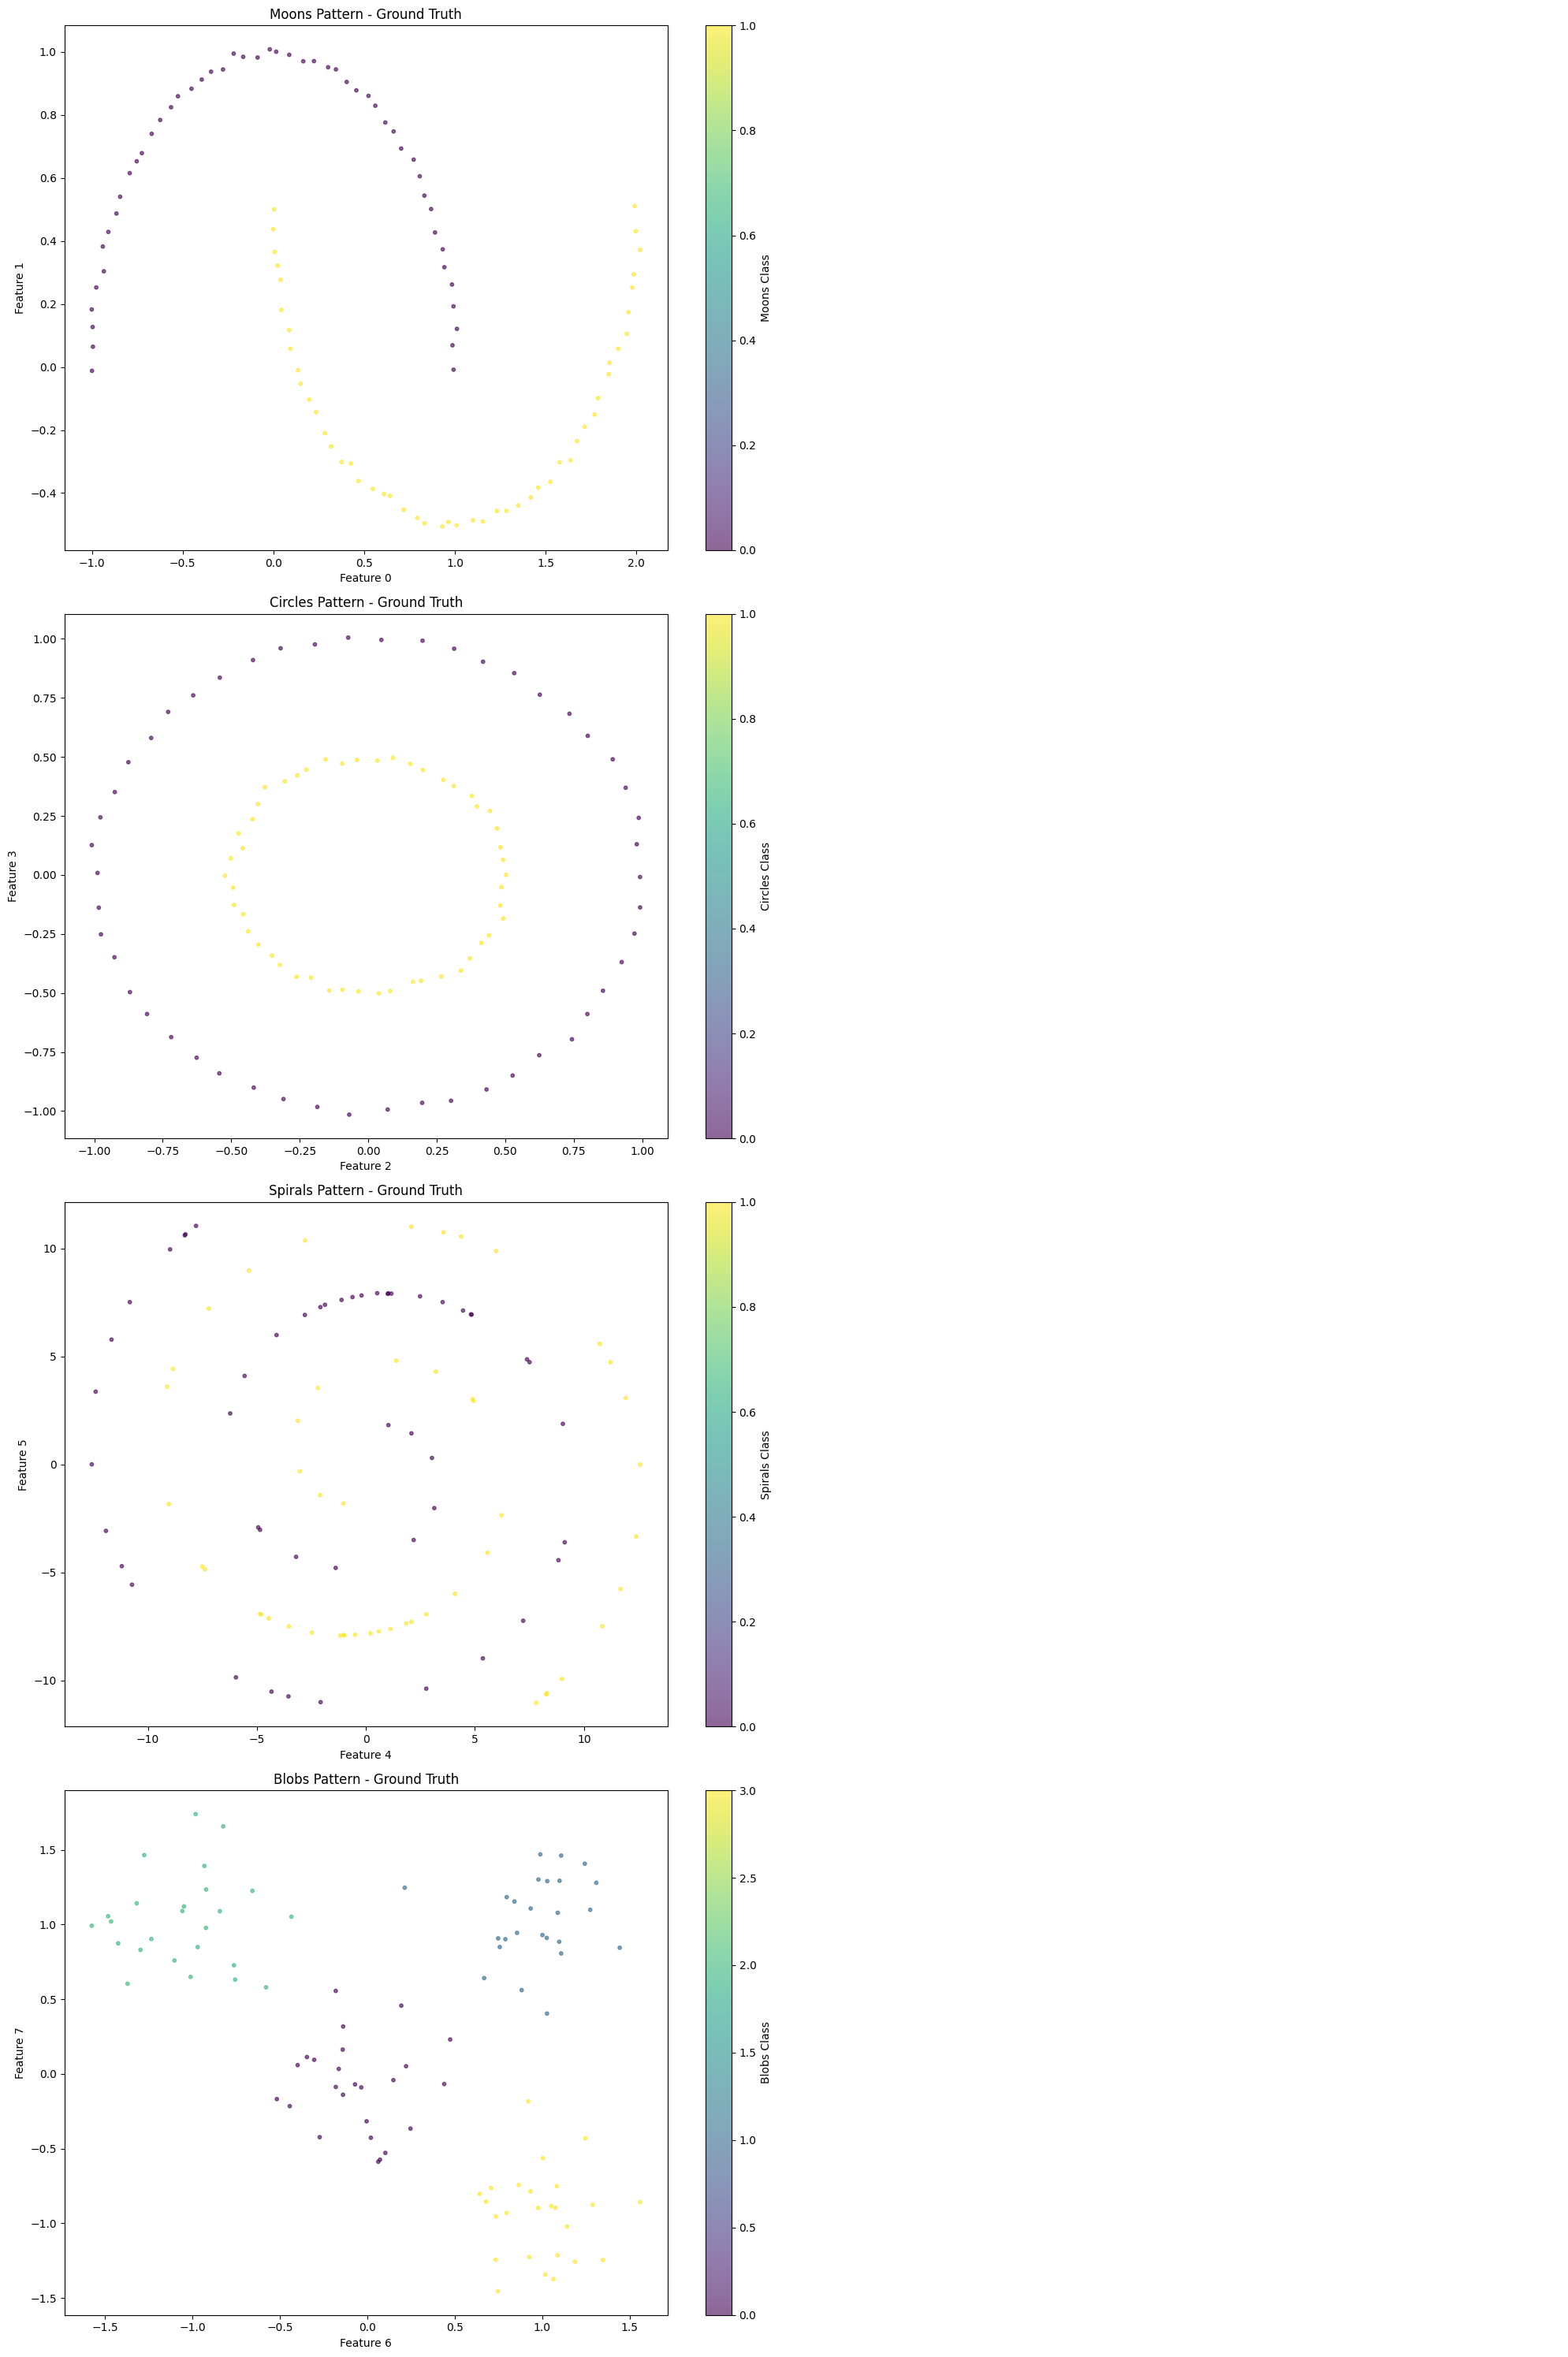

In [5]:
# Visualize the dataset
dataset.visualize()

In [6]:
dataset.label_mapping

{(0.0, 0.0, 0.0, 0.0): 0,
 (0.0, 0.0, 0.0, 1.0): 1,
 (0.0, 0.0, 0.0, 2.0): 2,
 (0.0, 0.0, 0.0, 3.0): 3,
 (0.0, 0.0, 1.0, 0.0): 4,
 (0.0, 0.0, 1.0, 1.0): 5,
 (0.0, 0.0, 1.0, 2.0): 6,
 (0.0, 0.0, 1.0, 3.0): 7,
 (1.0, 1.0, 0.0, 0.0): 8,
 (1.0, 1.0, 0.0, 1.0): 9,
 (1.0, 1.0, 0.0, 2.0): 10,
 (1.0, 1.0, 0.0, 3.0): 11,
 (1.0, 1.0, 1.0, 0.0): 12,
 (1.0, 1.0, 1.0, 1.0): 13,
 (1.0, 1.0, 1.0, 2.0): 14,
 (1.0, 1.0, 1.0, 3.0): 15}

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

import dataclasses
import pprint

import wandb

import tqdm

WANDB_PROJECT_NAME = "simple_regression"


@dataclasses.dataclass
class SimpleNetConfig:
    d_model: int
    n_layers: int
    dropout: float
    d_input: int = 8
    d_output: int = 16  # Changed to 16 for 16 classes


# Define a simple neural network


class SimpleNet(nn.Module):
    def __init__(self, cfg: SimpleNetConfig) -> None:
        """
        Initialize the neural network with multiple hidden layers for multi-class classification.
        """
        super(SimpleNet, self).__init__()

        self.cfg = cfg

        # Input layer: d_input features to d_model
        self.input_layer = nn.Linear(self.cfg.d_input, self.cfg.d_model)
        self.activation_fn = nn.ReLU()
        self.dropout = nn.Dropout(p=self.cfg.dropout)

        # Hidden layers with dropout
        self.hidden_layers = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Linear(self.cfg.d_model, self.cfg.d_model),
                    nn.ReLU(),
                    nn.Dropout(p=self.cfg.dropout),
                )
                for _ in range(cfg.n_layers)
            ]
        )

        # Output layer: d_model to 16 classes
        self.output_layer = nn.Linear(self.cfg.d_model, self.cfg.d_output)

    def forward(
        self,
        x: Float32[torch.Tensor, "batch features"],
    ) -> Float32[torch.Tensor, "batch num_classes"]:
        """
        Forward pass of the network for multi-class classification.

        :param x: Input tensor
        :return: Logits for each of the 16 classes
        """
        # Apply activation_fn and dropout after input layer
        x = self.dropout(self.activation_fn(self.input_layer(x)))

        # Hidden layers already have activation_fn and dropout
        x = self.hidden_layers(x)

        # No activation_fn or dropout after output layer (logits)
        x = self.output_layer(x)

        return x  # Return logits for all 16 classes

In [8]:
# TODO(bschoen): Move these to their own toy datasets directory


# Define a simple dataset
class SimpleDataset(Dataset):
    def __init__(self, num_samples: int = 1000):
        """
        Initialize the dataset with random samples.

        :param num_samples: Number of samples to generate
        """
        self.x = torch.randn(num_samples, 10)  # 10 input features
        self.y = torch.sum(self.x[:, :5], dim=1) - torch.sum(
            self.x[:, 5:], dim=1
        )  # Target is sum of first 5 features minus sum of last 5
        self.y += torch.randn(num_samples) * 0.1  # Add some noise

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(
        self, idx: int
    ) -> tuple[Float32[torch.Tensor, "features"], Float32[torch.Tensor, ""]]:
        return self.x[idx], self.y[idx]


class QuadraticDataset(Dataset):
    def __init__(self, num_samples: int = 1000):
        """
        Initialize the dataset with a quadratic pattern.

        :param num_samples: Number of samples to generate
        """
        self.x = torch.randn(num_samples, 5)  # 5 input features
        self.y = torch.sum(self.x**2, dim=1)  # Sum of squared features
        self.y += torch.randn(num_samples) * 0.1  # Add some noise

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(
        self, idx: int
    ) -> tuple[Float32[torch.Tensor, "features"], Float32[torch.Tensor, ""]]:
        return self.x[idx], self.y[idx]


class ExponentialDataset(Dataset):
    def __init__(self, num_samples: int = 1000):
        """
        Initialize the dataset with an exponential pattern.

        :param num_samples: Number of samples to generate
        """
        self.x = torch.randn(num_samples, 5)  # 5 input features
        self.y = torch.sum(torch.exp(self.x * 0.5), dim=1)  # Sum of exponentials
        self.y = (self.y - self.y.mean()) / self.y.std()  # Normalize
        self.y += torch.randn(num_samples) * 0.1  # Add some noise

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(
        self, idx: int
    ) -> tuple[Float32[torch.Tensor, "features"], Float32[torch.Tensor, ""]]:
        return self.x[idx], self.y[idx]


class SinusoidalDataset(Dataset):
    def __init__(self, num_samples: int = 1000):
        """
        Initialize the dataset with a sinusoidal pattern.

        :param num_samples: Number of samples to generate
        """
        self.x = torch.randn(num_samples, 5)  # 5 input features
        self.y = torch.sum(torch.sin(self.x), dim=1)  # Sum of sines
        self.y += torch.randn(num_samples) * 0.1  # Add some noise

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(
        self, idx: int
    ) -> tuple[Float32[torch.Tensor, "features"], Float32[torch.Tensor, ""]]:
        return self.x[idx], self.y[idx]


class InteractionDataset(Dataset):
    def __init__(self, num_samples: int = 1000):
        """
        Initialize the dataset with feature interactions.

        :param num_samples: Number of samples to generate
        """
        self.x = torch.randn(num_samples, 5)  # 5 input features
        self.y = (
            self.x[:, 0] * self.x[:, 1] + self.x[:, 2] * self.x[:, 3] + self.x[:, 4]
        )
        self.y += torch.randn(num_samples) * 0.1  # Add some noise

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(
        self, idx: int
    ) -> tuple[Float32[torch.Tensor, "features"], Float32[torch.Tensor, ""]]:
        return self.x[idx], self.y[idx]


class ComplexDataset(Dataset):
    def __init__(self, num_samples: int = 1000):
        """
        Initialize a complex dataset combining multiple patterns.

        :param num_samples: Number of samples to generate
        """
        self.x = torch.randn(num_samples, 10)  # 10 input features

        # Combine different patterns for each group of features
        self.y = torch.zeros(num_samples)

        # Quadratic pattern for first two features
        self.y += torch.sum(self.x[:, :2] ** 2, dim=1)

        # Exponential pattern for next two features
        self.y += torch.sum(torch.exp(self.x[:, 2:4] * 0.5), dim=1)

        # Sinusoidal pattern for next two features
        self.y += torch.sum(torch.sin(self.x[:, 4:6]), dim=1)

        # Interaction between next two features
        self.y += self.x[:, 6] * self.x[:, 7]

        # Linear combination of last two features
        self.y += 2 * self.x[:, 8] - 3 * self.x[:, 9]

        # Add non-linear transformation
        self.y = torch.tanh(self.y)

        # Normalize
        self.y = (self.y - self.y.mean()) / self.y.std()

        # Add some noise
        self.y += torch.randn(num_samples) * 0.05

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(
        self, idx: int
    ) -> tuple[Float32[torch.Tensor, "features"], Float32[torch.Tensor, ""]]:
        return self.x[idx], self.y[idx]


class MultiClassDataset(Dataset):
    def __init__(self, num_samples: int = 1000, num_classes: int = 10):
        """
        Initialize a multi-class dataset for classification tasks.

        :param num_samples: Number of samples to generate
        :param num_classes: Number of classes for classification
        """
        self.num_classes = num_classes
        self.x = torch.randn(num_samples, 10)  # 10 input features

        # Generate class probabilities
        logits = torch.zeros(num_samples, num_classes)

        # Create complex decision boundaries
        for i in range(num_classes):
            # Use different combinations of features for each class
            # - The sinusoidal term adds periodic non-linearity.
            # - The quadratic term adds parabolic curvature.
            # - The exponential term adds rapid growth for positive values.
            # - The interaction term captures pairwise feature interactions.

            logits[:, i] = (
                torch.sin(
                    self.x[:, i] + self.x[:, (i + 1) % 10]
                )  # Non-linear combination
                + self.x[:, (i + 2) % 10] ** 2  # Quadratic term
                + torch.exp(self.x[:, (i + 3) % 10] * 0.1)  # Exponential term
                + self.x[:, (i + 4) % 10] * self.x[:, (i + 5) % 10]  # Interaction term
            )

        # Convert logits to probabilities
        self.probs = F.softmax(logits, dim=1)

        # Sample classes based on probabilities
        self.y = torch.multinomial(self.probs, 1).squeeze()

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(
        self, idx: int
    ) -> tuple[Float32[torch.Tensor, "features"], Int64[torch.Tensor, ""]]:
        return self.x[idx], self.y[idx]

    def get_class_probabilities(self, idx: int) -> Float32[torch.Tensor, "num_classes"]:
        """
        Get the probability distribution over classes for a specific sample.

        :param idx: Index of the sample
        :return: Probability distribution over classes
        """
        return self.probs[idx]


class GeometricShapesDataset(torch.utils.data.Dataset):
    """
    A dataset that generates samples representing geometric shapes in a 2D space.
    Each sample is classified into one of several shape categories based on its features.

    This dataset creates complex decision boundaries based on geometric properties.

    Other potential ideas for multi-class datasets:
    1. Weather Prediction: Features like temperature, humidity, pressure, wind speed
       could be used to classify into weather types (sunny, rainy, snowy, etc.)
    2. Music Genre Classification: Audio features like tempo, spectral centroid,
       zero-crossing rate could be used to classify music into genres.
    3. Stellar Classification: Features like temperature, luminosity, mass, and
       chemical composition could be used to classify stars into types.

    :param num_samples: Number of samples to generate
    :param num_classes: Number of shape classes (default is 4: circle, square, triangle, ellipse)
    """

    def __init__(self, num_samples: int):
        self.num_samples = num_samples
        self.num_classes = 4
        self.x = torch.rand(
            num_samples, 4
        )  # 4 features: x, y, radius/side length, aspect ratio

        # Generate shape properties
        self.center_x = self.x[:, 0]
        self.center_y = self.x[:, 1]
        self.size = self.x[:, 2] * 0.5 + 0.5  # Ensure positive size
        self.aspect_ratio = self.x[:, 3] * 2 + 0.5  # Range from 0.5 to 2.5

        # Calculate probabilities for each class
        self.probs = torch.zeros(num_samples, self.num_classes)

        # Circle probability: higher when aspect ratio is close to 1
        self.probs[:, 0] = torch.exp(-5 * torch.abs(self.aspect_ratio - 1))

        # Square probability: higher when aspect ratio is close to 1 and center is close to origin
        self.probs[:, 1] = torch.exp(-5 * torch.abs(self.aspect_ratio - 1)) * torch.exp(
            -2 * (self.center_x**2 + self.center_y**2)
        )

        # Triangle probability: higher when size is inversely proportional to distance from origin
        self.probs[:, 2] = torch.exp(
            -2 * (self.size * (self.center_x**2 + self.center_y**2 + 1) - 1) ** 2
        )

        # Ellipse probability: higher for remaining cases (when other probabilities are low)
        self.probs[:, 3] = torch.clamp(
            1 - (self.probs[:, 0] + self.probs[:, 1] + self.probs[:, 2]), min=0
        )

        # Add a small epsilon to avoid zeros
        epsilon = 1e-8
        self.probs += epsilon

        # Normalize probabilities
        self.probs = F.normalize(self.probs, p=1, dim=1)

        # Ensure no NaNs or infinities
        self.probs = torch.nan_to_num(self.probs, nan=0.0, posinf=1.0, neginf=0.0)

        # Sample classes based on probabilities
        self.y = torch.multinomial(self.probs, 1).squeeze()

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(
        self, idx: int
    ) -> tuple[Float32[torch.Tensor, "features"], Int64[torch.Tensor, ""]]:
        return self.x[idx], self.y[idx]

    def get_class_probabilities(self, idx: int) -> Float32[torch.Tensor, "num_classes"]:
        """
        Get the probability distribution over classes for a specific sample.

        :param idx: Index of the sample
        :return: Probability distribution over classes
        """
        return self.probs[idx]


class SimpleClassificationDataset(Dataset):
    def __init__(
        self, num_samples: int = 1000, num_features: int = 4, num_classes: int = 4
    ):
        """
        Initialize a simple classification dataset.

        :param num_samples: Number of samples in the dataset
        :param num_features: Number of features for each sample
        :param num_classes: Number of classes for classification
        """
        self.num_samples = num_samples
        self.num_features = num_features
        self.num_classes = num_classes

        # Generate random features
        self.features: Float32[torch.Tensor, "num_samples num_features"] = torch.randn(
            num_samples, num_features
        )

        # Generate labels based on a simple rule
        self.labels: Int64[torch.Tensor, "num_samples"] = torch.zeros(
            num_samples, dtype=torch.long
        )

        for i in range(num_samples):
            # More complex classification rule: assign class based on feature interactions
            f1, f2, f3, f4 = self.features[i]  # Unpack features

            # Class 0: First feature dominates and is negative
            if f1 < -0.5 and f1 < f2 and f1 < f3 and f1 < f4:
                self.labels[i] = 0
            # Class 1: Product of first two features is large positive
            elif f1 * f2 > 0.5:
                self.labels[i] = 1
            # Class 2: Sum of last two features is close to zero
            elif abs(f3 + f4) < 0.1:
                self.labels[i] = 2
            # Class 3: All other cases
            else:
                self.labels[i] = 3

            # Add some noise to make it even harder
            if torch.rand(1).item() < 0.05:  # 5% chance of random label
                self.labels[i] = torch.randint(0, self.num_classes, (1,)).item()

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(
        self, idx: int
    ) -> tuple[Float32[torch.Tensor, "num_features"], Int64[torch.Tensor, ""]]:
        return self.features[idx], self.labels[idx]

    def get_class_distribution(self) -> dict[int, int]:
        """
        Get the distribution of classes in the dataset.

        :return: A dictionary with class labels as keys and their counts as values
        """
        return {i: (self.labels == i).sum().item() for i in range(self.num_classes)}


from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np

import matplotlib.pyplot as plt


class MoonsDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples: int, noise: float = 0.1, test_size: float = 0.2):
        """
        Initialize the Moons dataset.

        :param num_samples: Total number of samples to generate
        :param noise: Standard deviation of Gaussian noise added to the data
        :param test_size: Proportion of the dataset to include in the test split
        """
        # Generate the moons data
        X, y = make_moons(n_samples=num_samples, noise=noise, random_state=42)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )

        # Store the training data
        self.X = torch.tensor(X_train, dtype=torch.float32)
        self.y = torch.tensor(y_train, dtype=torch.long)

        # Store the test data separately
        self.X_test = torch.tensor(X_test, dtype=torch.float32)
        self.y_test = torch.tensor(y_test, dtype=torch.long)

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(
        self, idx: int
    ) -> tuple[Float32[torch.Tensor, "features"], Int64[torch.Tensor, ""]]:
        return self.X[idx], self.y[idx]

    def get_test_data(
        self,
    ) -> tuple[
        Float32[torch.Tensor, "num_samples features"],
        Int64[torch.Tensor, "num_samples"],
    ]:
        """
        Return the test data.

        :return: Tuple of test features and labels
        """
        return self.X_test, self.y_test

    def visualize(self) -> None:
        """
        Visualize the Moons dataset.
        """
        plt.figure(figsize=(10, 8))

        # Plot training data
        plt.scatter(
            self.X[:, 0],
            self.X[:, 1],
            c=self.y,
            cmap="coolwarm",
            alpha=0.7,
            s=50,
            edgecolors="black",
        )
        plt.title("Moons Dataset Visualization")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")

        # Add a legend
        plt.colorbar(label="Class")

        # Plot test data with different marker
        plt.scatter(
            self.X_test[:, 0],
            self.X_test[:, 1],
            c=self.y_test,
            cmap="coolwarm",
            alpha=0.7,
            s=50,
            edgecolors="black",
            marker="s",
        )

        # Add text to indicate train and test sets
        plt.text(
            0.05,
            0.95,
            "Train: circles\nTest: squares",
            transform=plt.gca().transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
        )

        plt.tight_layout()
        plt.show()

In [9]:
@dataclasses.dataclass
class TrainingConfig:
    # model
    model_cfg: SimpleNetConfig

    # data
    num_samples: int = 10000

    # training
    num_epochs: int = 1000
    test_interval: int = 100

    # optimizer
    learning_rate: float = 0.001
    batch_size: int = 32


@dataclasses.dataclass
class TrainingResult:

    model: nn.Module
    full_dataset: Dataset


# TODO(bschoen): Plot from optimizer
"""
params
lr
betas
eps
weight_decay
amsgrad
foreach
maximize
capturable
differentiable
fused
"""
# for param_group in optimizer.param_groups:
#    for key in param_group:
#        print(key)

# We'll use these in the next cell for training
# Initialize wandb
# wandb.init(
#     project=WANDB_PROJECT_NAME,
#    config=dataclasses.asdict(cfg),
# )


# returns the generated test and train datasets for convenience
def train(cfg: TrainingConfig) -> TrainingResult:

    # Determine the device to use
    device = (
        torch.device("mps")
        if torch.backends.mps.is_available()
        else torch.device("cpu")
    )
    print(f"Using device: {device}")

    # Create dataset and split into train and test
    full_dataset = GeometricDataset(num_samples=cfg.num_samples)
    train_size = int(0.8 * len(full_dataset))  # 80% for training
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, test_size]
    )

    # Create dataloaders for train and test sets
    train_dataloader = DataLoader(
        train_dataset, batch_size=cfg.batch_size, shuffle=True
    )
    test_dataloader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False)

    # Initialize the model, loss function, and optimizer
    model = SimpleNet(cfg=cfg.model_cfg)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=cfg.learning_rate)

    # watch model and criterion
    watch_model = False
    wandb.watch(
        [model],
        criterion=criterion,
        log_freq=100,  # note: this is per n *batches*, not epochs
        log="all",
    )

    # Training loop
    for epoch in range(cfg.num_epochs):
        model.train()
        epoch_loss = 0.0

        for batch_x, batch_y in train_dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            outputs = model(batch_x)

            loss = criterion(outputs, batch_y)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()

            epoch_loss += loss.item()

        # Calculate average loss for the epoch
        avg_loss = epoch_loss / len(train_dataloader)

        # Compute test loss every n epochs (or once at very end)
        if ((epoch + 1) % cfg.test_interval == 0) or (epoch == cfg.num_epochs - 1):

            # Compute test loss
            model.eval()
            test_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for batch_x, batch_y in test_dataloader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    test_outputs = model(batch_x)
                    test_loss += criterion(test_outputs, batch_y).item()
                    _, predicted = torch.max(test_outputs.data, 1)
                    total += batch_y.size(0)
                    correct += (predicted == batch_y).sum().item()
            avg_test_loss = test_loss / len(test_dataloader)
            accuracy = 100 * correct / total
            model.train()

            # print progress
            print(
                f"Epoch [{epoch+1}/{cfg.num_epochs}], "
                f"Train Loss: {avg_loss:.4f}, Test Loss: {avg_test_loss:.4f}, "
                f"Accuracy: {accuracy:.2f}%"
            )

            # Log metrics to wandb
            wandb.log(
                {
                    "epoch": epoch,
                    "train_loss": avg_loss,
                    "test_loss": avg_test_loss,
                    "accuracy": accuracy,
                }
            )

        # At least print test loss every 1/10 epochs
        elif ((epoch + 1) % (cfg.num_epochs // 10)) == 0:
            print(f"Epoch [{epoch+1}/{cfg.num_epochs}] Train Loss: {avg_loss:.6f}")

    # Finish the wandb run
    wandb.finish()

    print("Training completed!")
    return TrainingResult(model=model, full_dataset=full_dataset)

In [61]:
# TODO(bschoen): Use wandb to plot adam
cfg = TrainingConfig(
    model_cfg=SimpleNetConfig(d_model=4096, n_layers=2, dropout=0.7),
    num_samples=64,
    num_epochs=10000,  # Train for longer
    test_interval=100,
    learning_rate=1e-4,  # Adjust learning rate
    batch_size=128,  # Increase batch size
)

wandb.init(project=WANDB_PROJECT_NAME, config=dataclasses.asdict(cfg))

training_result = train(cfg)

Using device: mps
Epoch [100/10000], Train Loss: 1.7141, Test Loss: 4.6962, Accuracy: 15.38%
Epoch [200/10000], Train Loss: 0.9970, Test Loss: 5.6362, Accuracy: 15.38%
Epoch [300/10000], Train Loss: 0.8045, Test Loss: 6.4223, Accuracy: 15.38%
Epoch [400/10000], Train Loss: 0.5482, Test Loss: 7.1717, Accuracy: 15.38%
Epoch [500/10000], Train Loss: 0.3808, Test Loss: 7.8098, Accuracy: 23.08%
Epoch [600/10000], Train Loss: 0.2813, Test Loss: 8.6418, Accuracy: 23.08%
Epoch [700/10000], Train Loss: 0.2402, Test Loss: 9.2415, Accuracy: 23.08%
Epoch [800/10000], Train Loss: 0.1504, Test Loss: 9.5211, Accuracy: 23.08%
Epoch [900/10000], Train Loss: 0.2105, Test Loss: 10.2991, Accuracy: 23.08%
Epoch [1000/10000], Train Loss: 0.1433, Test Loss: 10.6787, Accuracy: 23.08%
Epoch [1100/10000], Train Loss: 0.0710, Test Loss: 10.5908, Accuracy: 23.08%
Epoch [1200/10000], Train Loss: 0.1645, Test Loss: 10.5831, Accuracy: 23.08%
Epoch [1300/10000], Train Loss: 0.0472, Test Loss: 10.9766, Accuracy: 23.08

accuracy,▁▁▅▅▅▅▅▅▅▅▅▅▅▅█▅▅▅▅██▅▅▅▅▅█▅▅▅▅█▅▅▅▅▅▅▅▅
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
train_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,23.07692
epoch,9999
test_loss,41.18648
train_loss,1e-05


Training completed!


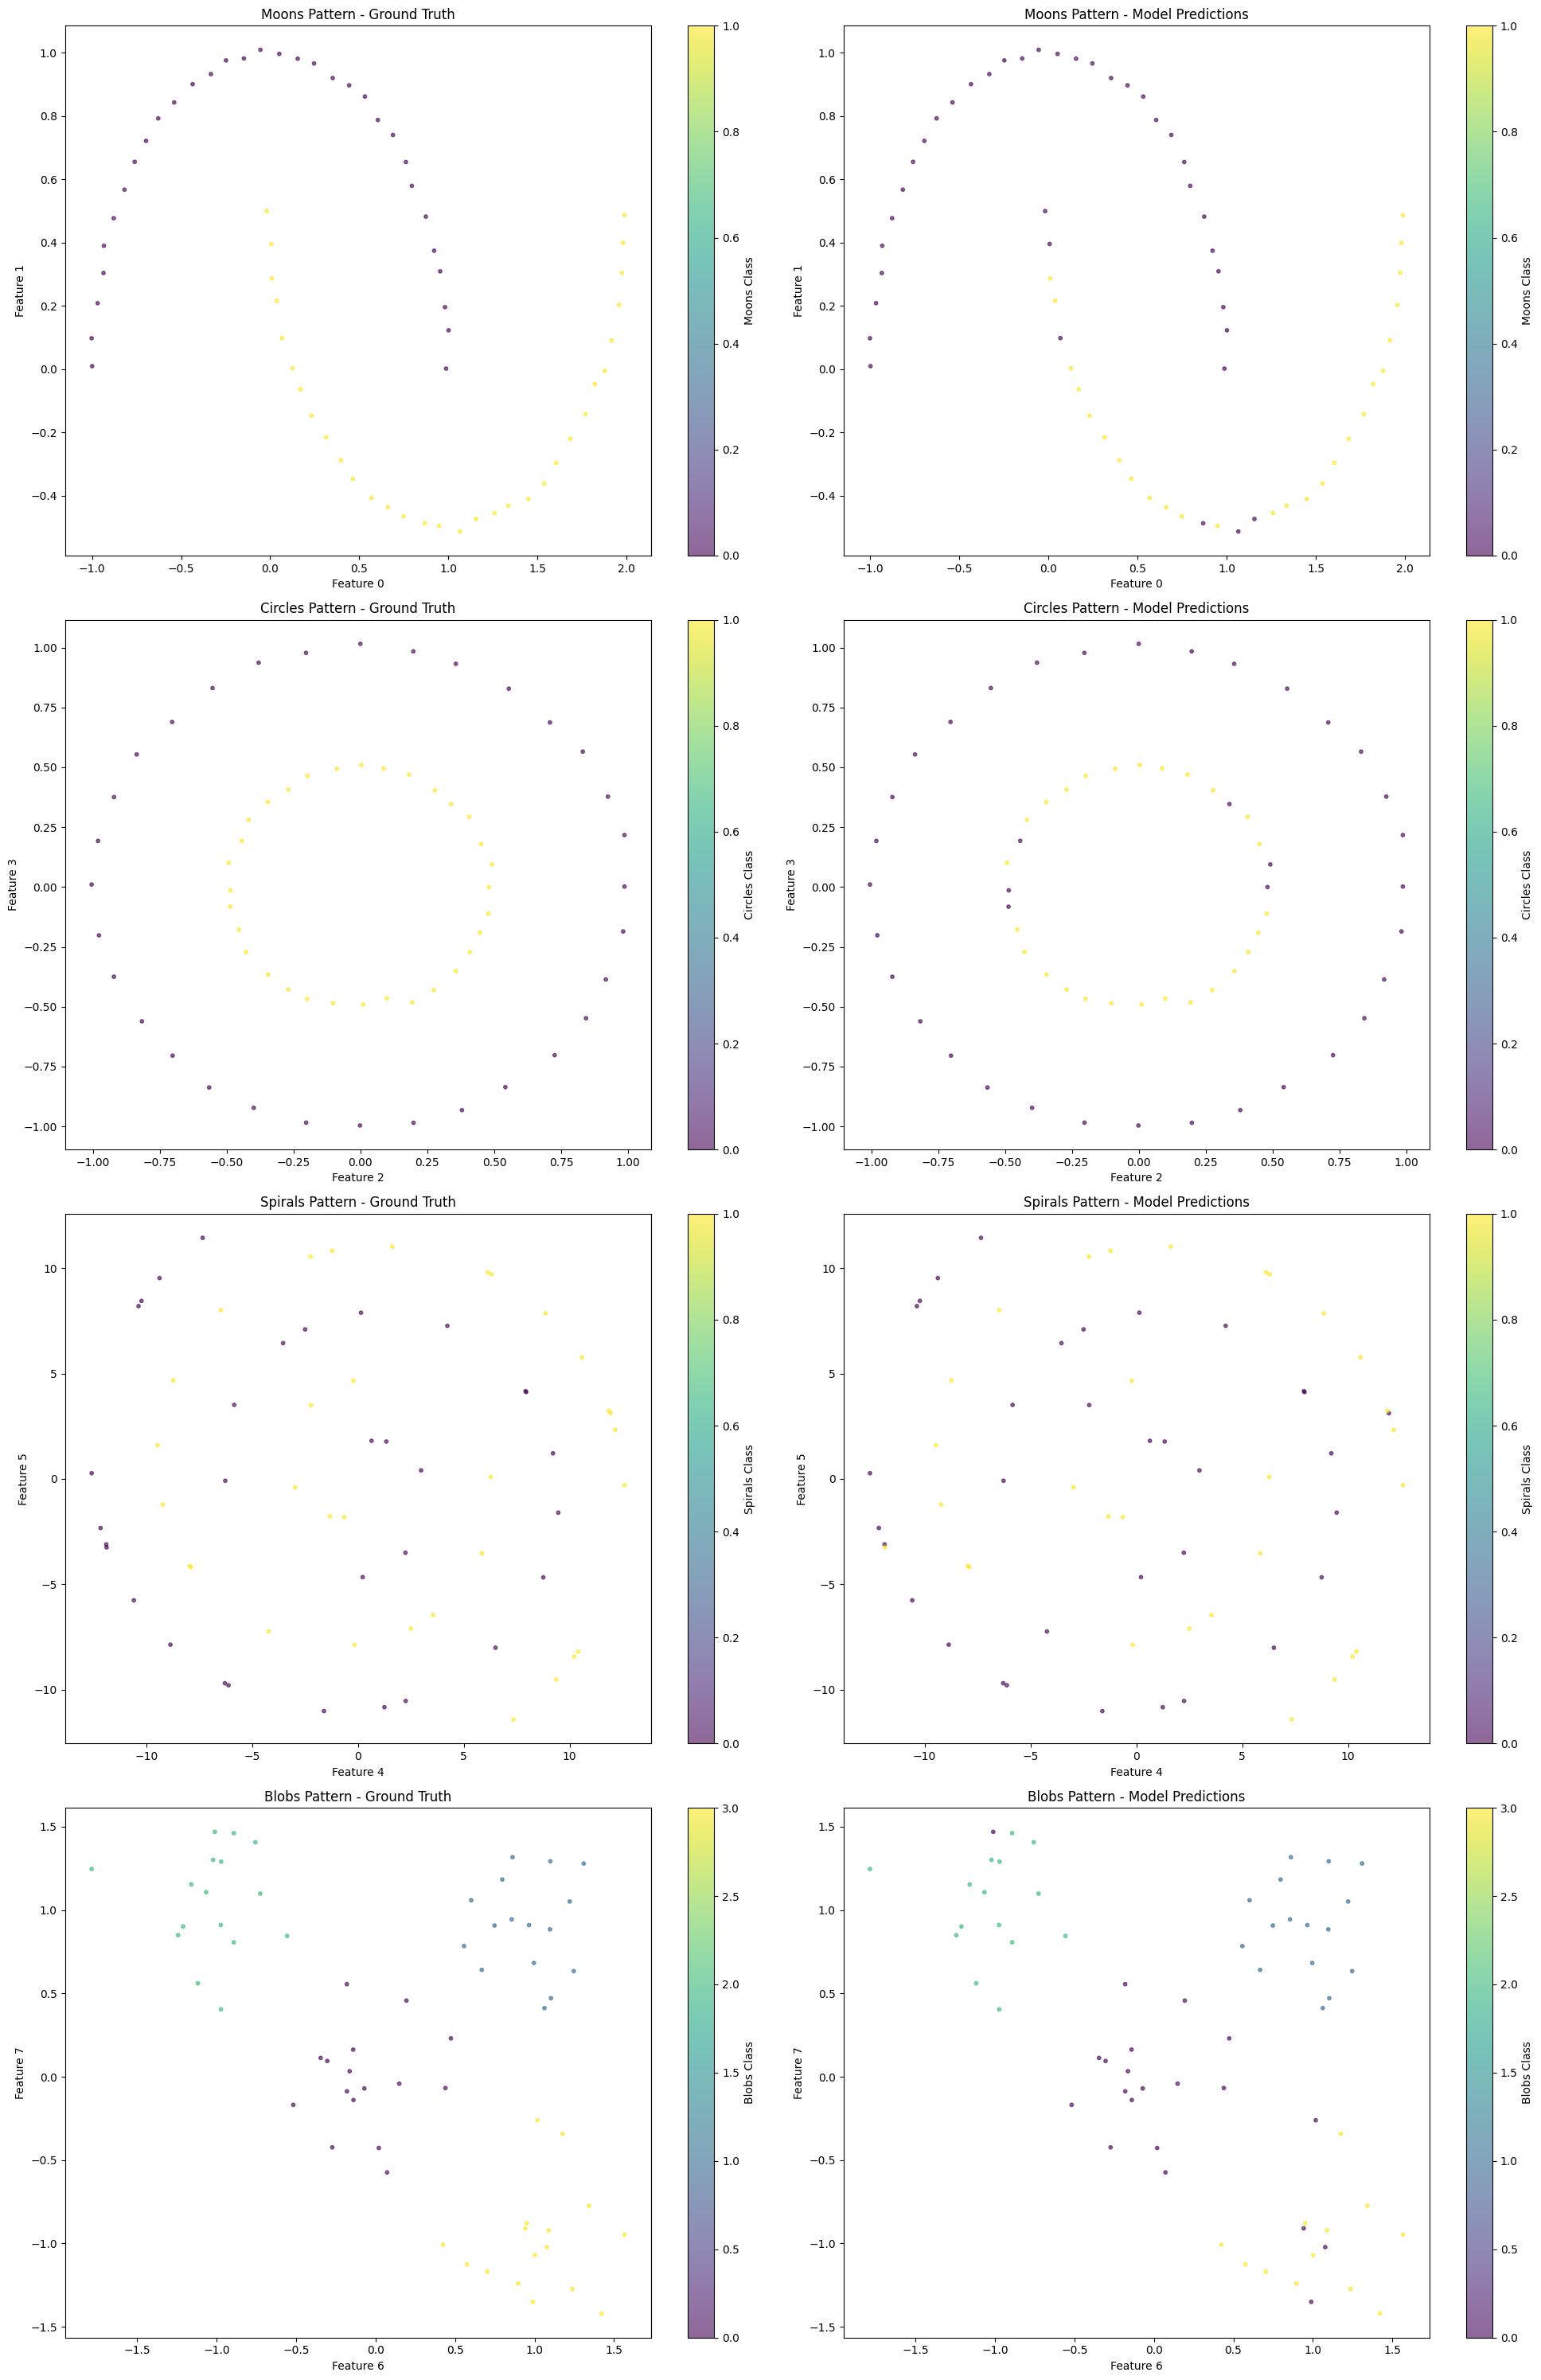

In [62]:
training_result.full_dataset.visualize(model=training_result.model)

In [12]:
assert False

AssertionError: 

# Sweep Configuration For Hyperparameter Search

In [ ]:
sweep_configuration = {
    "name": "sweepdemo",
    "method": "bayes",
    "metric": {"goal": "minimize", "name": "test_loss"},
    "parameters": {
        "d_model": {"values": [8, 16, 32, 64, 128]},
        "n_layers": {"min": 1, "max": 16},
        "learning_rate": {
            # a flat distribution between 0 and 0.1
            "distribution": "uniform",
            "min": 0,
            "max": 0.1,
        },
        "batch_size": {
            "distribution": "q_log_uniform_values",
            "max": 256,
            "min": 32,
            "q": 8,
        },
        "num_epochs": {"value": 100},
        "test_interval": {"value": 1000},
        # "optimizer": {"values": ["adam", "sgd", "adamw", "rmsprop"]},
    },
}

In [ ]:
def train_wandb() -> None:

    # construct training config from wandb

    wandb.init(project=WANDB_PROJECT_NAME)

    # TODO(bschoen): What's the usual way to init config from here so don't copy explicitly
    # - usually will have this as completely flatten so can directly grab from
    #
    # `wandb.config` accesses current sweep params
    cfg = TrainingConfig(
        model_cfg=SimpleNetConfig(
            d_model=wandb.config["d_model"],
            n_layers=wandb.config["n_layers"],
        ),  # Increase model capacity
        num_samples=1000,
        num_epochs=wandb.config["num_epochs"],
        test_interval=wandb.config["test_interval"],
        learning_rate=wandb.config["learning_rate"],
        batch_size=wandb.config["batch_size"],
    )

    train(cfg)

In [ ]:
wandb.agent?

## Intuition on Hyperparam Runs

* Bad hyperparameters are usually clearly worse by the end of the **first 1-2 epochs.**

* You can manually abort runs that don't look promising, or you can try to do it automatically
  * **Hyperband** is a popular algorithm for this.

* Starting with a smaller ResNet than the full ResNet34 is a good idea. 
  * Good hyperparameters on the small model tend to transfer over to the larger model because the architecture and the data are the same


    * the main difference is the **larger model** may require **more regularization** to prevent overfitting.

In [ ]:
sweep_id = wandb.sweep(
    sweep=sweep_configuration,
    project=WANDB_PROJECT_NAME,
)

num_trials = 100

# Inu
# TODO(bschoen): Use hyperband to abort sweep early [](https://www.jmlr.org/papers/volume18/16-558/16-558.pdf)
# - popular to use
#
# note: Larger batch size increases GPU memory usage and doubling batch size often allows doubling learning rate, up to a point where this relationship breaks down.
wandb.agent(
    sweep_id=sweep_id,
    function=train_wandb,
    count=num_trials,
)

wandb.finish()

# Scaling Laws

In [ ]:
# MSE - pretty clean scaling on model size: https://wandb.ai/bronsonschoen-personal-use/simple_regression/sweeps/c0ivdnhj?nw=nwuserbronsonschoen
#
# CrossEntropy
# - https://wandb.ai/bronsonschoen-personal-use/simple_regression/sweeps/m0p58ake?nw=nwuserbronsonschoen
#
#
sweep_configuration = {
    "name": "scaling_laws",
    # important that this is random, so it shows everything
    "method": "random",
    "metric": {"goal": "minimize", "name": "test_loss"},
    "parameters": {
        "d_model": {
            "values": [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
        },
        # "d_model": {"min": 1, "max": 4096},
        "n_layers": {"value": 4},
        "batch_size": {"value": 64},
        # "num_samples": { "values": [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]},
        "num_samples": {"value": 100000},
        "num_epochs": {"value": 1},
        "test_interval": {"value": 1e20},
        # "optimizer": {"values": ["adam", "sgd", "adamw", "rmsprop"]},
    },
}

In [ ]:
import math


def train_wandb_scaling() -> None:

    # construct training config from wandb

    wandb.init(project=WANDB_PROJECT_NAME)

    d_model = wandb.config["d_model"]
    num_samples = wandb.config["num_samples"]

    # learning rate scales at `1 / sqrt(d_model)`
    base_learning_rate = 1e-2
    learning_rate = base_learning_rate * (1 / math.sqrt(d_model))

    # TODO(bschoen): What's the usual way to init config from here so don't copy explicitly
    # - usually will have this as completely flatten so can directly grab from
    #
    # `wandb.config` accesses current sweep params
    cfg = TrainingConfig(
        model_cfg=SimpleNetConfig(
            d_model=d_model,
            n_layers=wandb.config["n_layers"],
        ),  # Increase model capacity
        num_samples=num_samples,
        num_epochs=wandb.config["num_epochs"],
        test_interval=wandb.config["test_interval"],
        learning_rate=learning_rate,
        batch_size=wandb.config["batch_size"],
    )

    train(cfg)

In [ ]:
sweep_id = wandb.sweep(
    sweep=sweep_configuration,
    project=WANDB_PROJECT_NAME,
)

num_trials = 100

# Inu
# TODO(bschoen): Use hyperband to abort sweep early [](https://www.jmlr.org/papers/volume18/16-558/16-558.pdf)
# - popular to use
#
# note: Larger batch size increases GPU memory usage and doubling batch size often allows doubling learning rate, up to a point where this relationship breaks down.
wandb.agent(
    sweep_id=sweep_id,
    function=train_wandb_scaling,
    count=num_trials,
)

wandb.finish()

In [ ]:
# Evaluate the model (optional)
model.eval()
with torch.no_grad():

    test_x = torch.randn(100, 10)  # Generate some test data
    test_x.to(device)
    test_y = model(test_x)

    print("Sample predictions:", test_y[:5].numpy())